# Calculate and save footprints over entire period.


Needs:'Zm','Zo','hpbl','L','v_sigma','u*','wind_dir'

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [52]:
dpath = 'C:/highfreq/BB/footprint/Kljun_FFP_Inputs.csv'

df = pd.read_csv(dpath,parse_dates=['TIMESTAMP'],index_col='TIMESTAMP')

df['Subset'] = 'N/A'
df.loc[((df.index.month==6)&(df.index.day==21)&(df.index.year==2021)),'Subset']='Bday_21'
df.loc[((df.index.month==6)&(df.index.day==21)&(df.index.year==2023)),'Subset']='Bday_23'



df.to_csv('_Temp/FP_Run.csv')
# df.loc[df['USTAR']>.10].dropna(how='any')[0:5].to_csv('_Temp/FP_Run.csv')#.head()


In [54]:
import FFP_Asssment
import importlib
importlib.reload(FFP_Asssment)


Site_Config = '../../Biomet.net/Python/ini_files/site_configurations/BB.ini'
Basemap = 'Inputs/BBECA_Eco_Classification.geojson'
Basemap_Class = 'Class'

FFP = FFP_Asssment.RunClimatology('BB',Site_Config,Basemap=Basemap,Basemap_Class=Basemap_Class,
                                  Subsets='Subset')


# print('A')

Rasterizing bassemap
48 records flagged for missing data
No valid input records for Bday_21
10 records flagged for low USTAR
Processing: 38 out of 48 input records for Bday_23
Processing Batch 0:38


In [50]:
len(FFP.FFP_Climatology.items())

2

0.999249440803909


(800.0, 200.0)

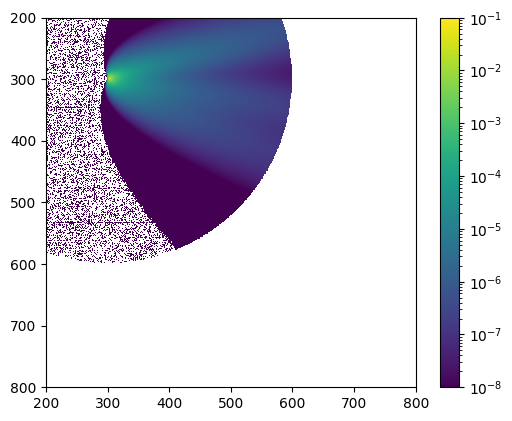

In [32]:

from matplotlib.colors import LogNorm


fclim_2d = FFP.fclim_2d.copy()

plt.figure()
plt.imshow(fclim_2d,norm=LogNorm(vmin=1e-8, vmax=1e-1))
plt.colorbar()
print(np.nansum(fclim_2d))
plt.xlim(200,800)
plt.ylim(800,200)


,wind_dir,TIMESTAMP
60839,166.47260,2023-06-21 12:00:00
60840,168.95616,2023-06-21 12:30:00


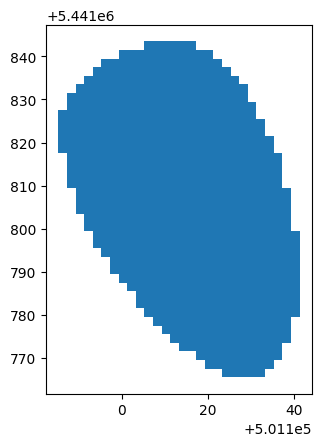

In [144]:
# fclim_2d = FFP.fclim_2d.copy()
# fclim_2d_r = FFP.fclim_2d.copy()*0
# sf = np.sort(fclim_2d, axis=None)[::-1]
# msf = np.ma.masked_array(sf, mask=(np.isnan(sf) | np.isinf(sf))) 
# csf = msf.cumsum().filled(np.nan)

# for r in FFP.rs:
#     sfv = sf[np.where(csf>=r)].max()
#     fclim_2d_r[np.where(fclim_2d>=sfv)]=r

# plt.figure()
# plt.imshow(fclim_2d_r)
# plt.colorbar()
# plt.xlim(25,175)

# plt.ylim(25,175)

FFP.contour_levels.loc[FFP.contour_levels['Interval']=='Bday_22'].plot()

FFP.Data.loc[((FFP.Data['Subset']=='Bday_23')&(FFP.Data['process']==1)),['wind_dir','TIMESTAMP']]
# FFP.Data.head()

0.8999999761581421
0.8999999761581421
0.75
0.8999999761581421
0.5
0.8999999761581421
0.75
0.75
0.8999999761581421
nan


<Axes: >

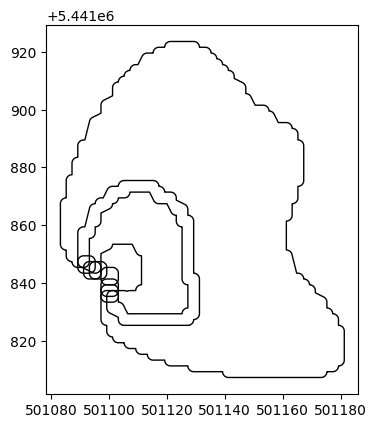

In [120]:
import pprint
import rasterio
from rasterio import features

with rasterio.open('_Temp/BB_FFP_Clim_2m_.tif') as src:
    fclim_2d = src.read(1)


    # fclim_2d = FFP.fclim_2d.copy()
fclim_2d_r = fclim_2d*0
sf = np.sort(fclim_2d, axis=None)[::-1]
msf = np.ma.masked_array(sf, mask=(np.isnan(sf) | np.isinf(sf))) 
csf = msf.cumsum().filled(np.nan)

for r in FFP.rs:
    # print(r)
    sfv = sf[np.where(csf>=r)].max()
    fclim_2d_r[np.where(fclim_2d>=sfv)]=r

fclim_2d_r[fclim_2d_r==0]=np.nan

Mask = fclim_2d_r*0+1

Mask = np.array(Mask,dtype=bool)

shapes = features.shapes(fclim_2d_r,mask=Mask,transform=src.transform)


feature = {"type": "Feature", "properties": {}, "geometry": {}}
FeatureCollection = {
    "type": "FeatureCollection",
    "features": []
}


for s in shapes:
    print(s[1])
    feature["properties"] = {'r':s[1],'Interval':FFP.sub_name,'BandID':1}
    feature["geometry"] = s[0]
    FeatureCollection['features'].append(feature.copy())
    # print(feature)


S_F = FFP.dx

FeatureCollection
gdf = gpd.GeoDataFrame.from_features(FeatureCollection["features"])
gdf.geometry = gdf.geometry.simplify(FFP.dx/S_F).buffer(FFP.dx/S_F, join_style=1).buffer(FFP.dx/S_F, join_style=1)
# gdf.geometry = gdf.geometry.buffer(FFP.dx, cap_style=3).buffer(-FFP.dx, cap_style=3)
gdf[gdf['r']>.5].plot(color='None',edgecolor='k')
# FeatureCollection["features"]

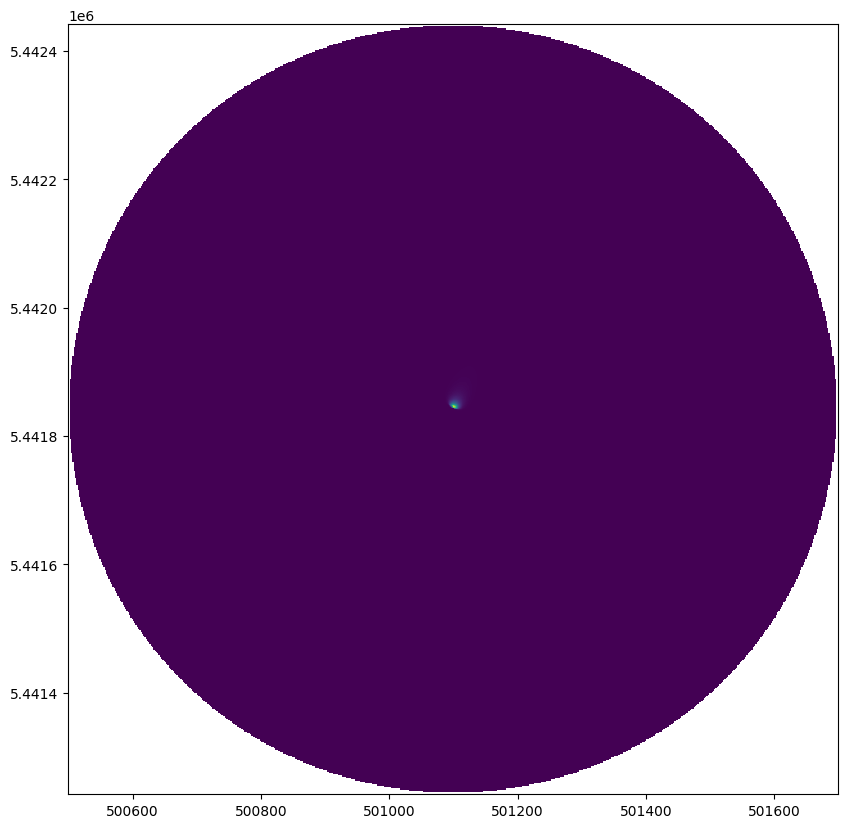

In [139]:
import pprint
import rasterio
from rasterio import features
from rasterio.plot import show

fig,ax = plt.subplots(figsize=(10,10))
with rasterio.open('_Temp/BB_FFP_Clim_2m_.tif',norm=LogNorm(vmin=1e-6, vmax=1e-1)) as src:
    # fclim_2d = src.read(1)
    show(src,ax=ax)


In [71]:
gdf

,geometry,r,Interval,BandID
0,"POLYGON ((501099.261 5441871.501, 501099.261 5...",0.75,Climatology,1
1,"POLYGON ((501089.261 5441861.501, 501089.261 5...",0.75,Climatology,1
2,"POLYGON ((501099.261 5441861.501, 501099.261 5...",0.50,Climatology,1
3,"POLYGON ((501119.261 5441921.501, 501139.261 5...",0.90,Climatology,1
4,"POLYGON ((500099.261 5442841.501, 500099.261 5...",NaN,Climatology,1


In [35]:
import geopandas as gpd
study_area = json.loads("""
 {"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[36.394272, -18.626726], [36.394272, -18.558391], [36.489716, -18.558391], [36.489716, -18.626726], [36.394272, -18.626726]]]}}]}
""")
gdf = gpd.GeoDataFrame.from_features(study_area["features"])
print(gdf.head())

study_area

                                            geometry
0  POLYGON ((36.39427 -18.62673, 36.39427 -18.558...


{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[36.394272, -18.626726],
      [36.394272, -18.558391],
      [36.489716, -18.558391],
      [36.489716, -18.626726],
      [36.394272, -18.626726]]]}}]}

<Axes: >

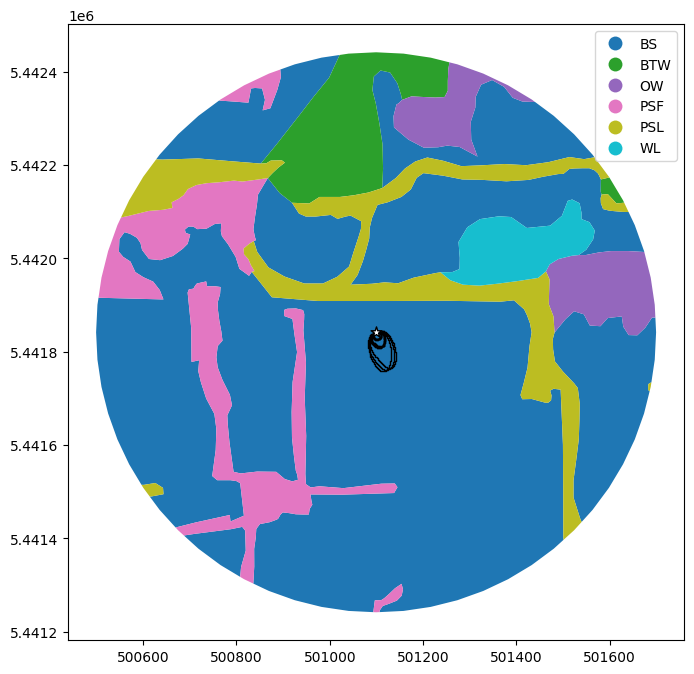

In [145]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(8,8))
FFP.baseVector.plot(ax=ax,column='Code',legend=True)
FFP.contour_levels.plot(ax=ax,edgecolor='k',facecolor='None')
FFP.Site_UTM.plot(ax=ax,marker='*',color='white',edgecolor='k',markersize=65)

In [104]:
# from IPython.display import IFrame

# file = '_Temp/BB_FFP_Clim_2m_Bday.html'

# with open(file) as t:
#     html = t.read()

# local_html_file = "<iframe sandbox='allow-scripts allow-forms' style='display:block; margin:0px;' frameborder='0' srcdoc='"+html+"' />"



from IPython.display import HTML
HTML('''<iframe srcdoc="<p>Hello world!</p>" src="demo_iframe_srcdoc.htm">
  <p>Your browser does not support iframes.</p>
</iframe>''')
# html


c:\MM_Py\FFP_Overlay\.venv\lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


 <iframe src="c:\MM_Py\FFP_Overlay/_Temp/BB_FFP_Clim_2m_Bday.html" title="W3Schools Free Online Web Tutorials"></iframe> 

In [100]:

from IPython.display import display, HTML

display(HTML(local_html_file))